# MNIST Single Layer Network

**Note**: This notebook is designed to run on GPU runtime.

**[MSL-01]**

Install libraries.

In [ ]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.1
jax                           0.3.21
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[MSL-02]**

Import modules.

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame
from tensorflow.keras.datasets import mnist

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state

plt.rcParams.update({'font.size': 12})

**[MSL-03]**

Download the MNIST dataset and store into NumPy arrays.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape([-1, 784]).astype('float32') / 255
test_images = test_images.reshape([-1, 784]).astype('float32') / 255
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

11501568/11490434 [==============================] - 0s 0us/step


**[MSL-04]**

Define a function to split the dataset into batches.

In [ ]:
def create_batches(data, batch_size):
    num_batches, mod = divmod(len(data), batch_size)
    data_batched = np.array_split(data[:num_batches * batch_size], num_batches)
    if mod: # Last batch is smaller than batch_size
        data_batched.append(data[num_batches * batch_size:])
    data_batched = [jnp.asarray(x) for x in data_batched]
    return data_batched

**[MSL-05]**

Define a model for the softmax estimation with a single hidden layer.

In [ ]:
class SingleLayerSoftmaxModel(nn.Module):
    num_nodes: int = 1024

    @nn.compact
    def __call__(self, x, get_logits=False):
        x = nn.Dense(features=self.num_nodes)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        if get_logits:
            return x
        x = nn.softmax(x)
        return x

**[MSL-06]**

Generate initial parameter values.

In [ ]:
key, key1 = random.split(random.PRNGKey(0))
variables = SingleLayerSoftmaxModel().init(key1, train_images[0:1])

jax.tree_util.tree_map(lambda x: x.shape, variables['params'])

FrozenDict({
    Dense_0: {
        bias: (1024,),
        kernel: (784, 1024),
    },
    Dense_1: {
        bias: (10,),
        kernel: (1024, 10),
    },
})

**[MSL-07]**

Create a training state object.

In [ ]:
state = train_state.TrainState.create(
    apply_fn=SingleLayerSoftmaxModel().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.001))

**[MSL-08]**

Define a loss function as the categorical cross entoropy.

In [ ]:
@jax.jit
def loss_fn(params, state, inputs, labels):
    logits = state.apply_fn({'params': params}, inputs, get_logits=True)
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    acc = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))
    return loss, acc

**[MSL-09]**

Define a function to apply a single training step that returns a new training state.

In [ ]:
@jax.jit
def train_step(state, inputs, labels):
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(
        state.params, state, inputs, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, acc

**[MSL-10]**

Define a function to apply the training steps for one epoch.

In [ ]:
def train_epoch(state, input_batched, label_batched, eval=False):
    loss_history, acc_history = [], []
    for inputs, labels in zip(input_batched, label_batched):
        new_state, loss, acc = train_step(state, inputs, labels)
        if not eval:
            state = new_state
        loss_history.append(jax.device_get(loss).tolist())
        acc_history.append(jax.device_get(acc).tolist())
    return state, np.mean(loss_history), np.mean(acc_history)

**[MSL-11]**

Define a funtion to repeat the training steps for multiple epochs.

In [ ]:
def fit(state, train_inputs, train_labels, test_inputs, test_labels,
        epochs, batch_size):

    train_inputs_batched = create_batches(train_inputs, batch_size)
    train_labels_batched = create_batches(train_labels, batch_size)
    test_inputs_batched = create_batches(test_inputs, batch_size)
    test_labels_batched = create_batches(test_labels, batch_size)

    loss_history_train, acc_history_train = [], []
    loss_history_test, acc_history_test = [], []

    for epoch in range(1, epochs+1):
        state, loss_train, acc_train = train_epoch(
            state, train_inputs_batched, train_labels_batched)
        loss_history_train.append(loss_train)
        acc_history_train.append(acc_train)

        _ , loss_test, acc_test = train_epoch(
            state, test_inputs_batched, test_labels_batched, eval=True)
        loss_history_test.append(loss_test)
        acc_history_test.append(acc_test)

        print ('Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f} / '.format(
            epoch, loss_train, acc_train), end='', flush=True)
        print ('Loss(Test): {:.4f}, Accuracy(Test): {:.4f}'.format(
            loss_test, acc_test), flush=True)
  
    history = {'loss_train': loss_history_train,
               'acc_train': acc_history_train,
               'loss_test': loss_history_test,
               'acc_test': acc_history_test}
  
    return state, history

**[MSL-12]**

Repeat the training steps for multiple epochs.

In [ ]:
%%time
state, history = fit(state, 
                     train_images, train_labels, test_images, test_labels,
                     epochs=16, batch_size=128)

Epoch: 1, Loss: 0.2681, Accuracy: 0.9236 / Loss(Test): 0.1559, Accuracy(Test): 0.9503
Epoch: 2, Loss: 0.1035, Accuracy: 0.9693 / Loss(Test): 0.1101, Accuracy(Test): 0.9642
Epoch: 3, Loss: 0.0629, Accuracy: 0.9815 / Loss(Test): 0.0864, Accuracy(Test): 0.9724
Epoch: 4, Loss: 0.0411, Accuracy: 0.9888 / Loss(Test): 0.0748, Accuracy(Test): 0.9760
Epoch: 5, Loss: 0.0278, Accuracy: 0.9929 / Loss(Test): 0.0737, Accuracy(Test): 0.9774
Epoch: 6, Loss: 0.0190, Accuracy: 0.9956 / Loss(Test): 0.0762, Accuracy(Test): 0.9765
Epoch: 7, Loss: 0.0130, Accuracy: 0.9972 / Loss(Test): 0.0738, Accuracy(Test): 0.9779
Epoch: 8, Loss: 0.0087, Accuracy: 0.9986 / Loss(Test): 0.0763, Accuracy(Test): 0.9784
Epoch: 9, Loss: 0.0069, Accuracy: 0.9989 / Loss(Test): 0.0729, Accuracy(Test): 0.9809
Epoch: 10, Loss: 0.0135, Accuracy: 0.9957 / Loss(Test): 0.0799, Accuracy(Test): 0.9790
Epoch: 11, Loss: 0.0096, Accuracy: 0.9973 / Loss(Test): 0.0874, Accuracy(Test): 0.9783
Epoch: 12, Loss: 0.0075, Accuracy: 0.9978 / Loss(Tes

**[MSL-13]**

Show charts of the accuracy history and the loss history.

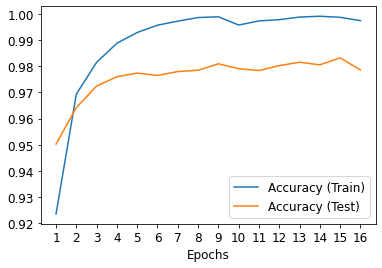

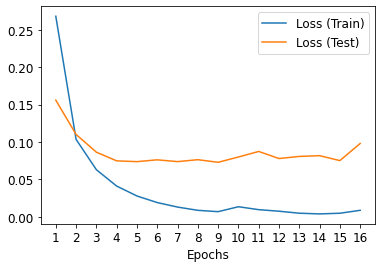

In [ ]:
df = DataFrame({'Accuracy (Train)': history['acc_train'],
                'Accuracy (Test)': history['acc_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'Loss (Train)': history['loss_train'],
                'Loss (Test)': history['loss_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

**[MSL-14]**

Show sample images with prediction results.

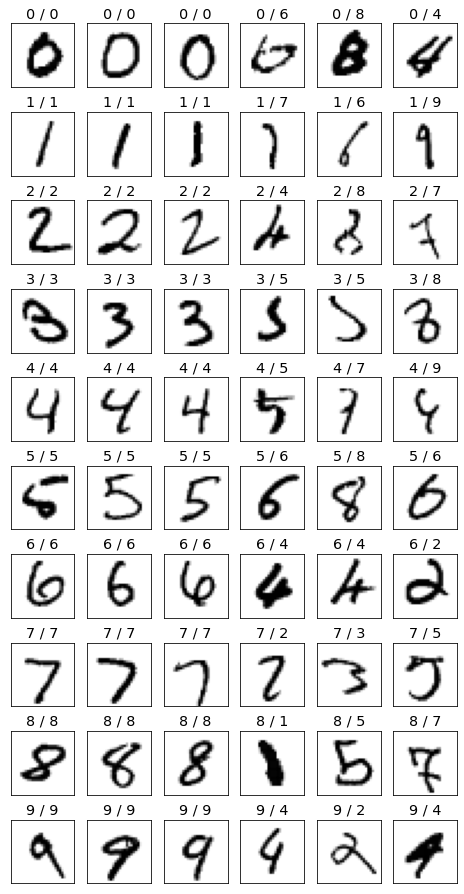

In [ ]:
predictions = jax.device_get(
    state.apply_fn({'params': state.params}, test_images))

df = DataFrame({'pred': list(map(np.argmax, predictions)),
                'label': list(map(np.argmax, jax.device_get(test_labels)))})
correct = df[df['pred']==df['label']]
incorrect = df[df['pred']!=df['label']]

fig = plt.figure(figsize=(8, 16))
for i in range(10):
    indices = list(correct[correct['pred']==i].index[:3]) \
                + list(incorrect[incorrect['pred']==i].index[:3])
    for c, image in enumerate(test_images[indices]):
        subplot = fig.add_subplot(10, 6, i*6+c+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.set_title('{} / {}'.format(i, df['label'][indices[c]]))
        subplot.imshow(image.reshape([28, 28]),
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)